In [69]:
import pandas as pd 
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [85]:
data_path = './result/weater_taxi_jun.csv'

data_base_path = './result/'
od_path = data_base_path+'od_june.npy'
pu_count_path = data_base_path+'pu_count_june.csv'

In [86]:
df = pd.read_csv(data_path)
pu_count_df = pd.read_csv(pu_count_path)

# Data Preparation 

In [87]:
# Data preparation, remove outliers 
df = df[df['trip_time']>5]
df = df[df['rate']<5]
df = df[df['total_amount']<200]
df['rate'] = abs(df['rate'])
df['total_amount'] = abs(df['total_amount'])

pu_cond = (df['PULocationID']!=263) &(df['PULocationID']!=264) &(df['PULocationID']!=265)
do_cond = (df['DOLocationID']!=263) &(df['DOLocationID']!=264) &(df['DOLocationID']!=265)
df = df[pu_cond & do_cond]
df.shape

(5331377, 16)

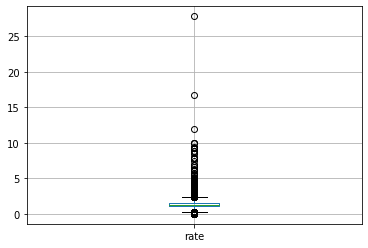

In [88]:
boxplot = df.boxplot(column=['rate'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fbf25a90f28>]],
      dtype=object)

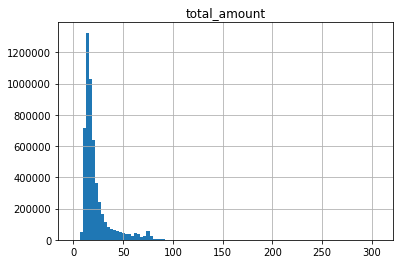

In [89]:
 df.hist(column=['total_amount'],bins=100)

In [90]:
total_amount = df['total_amount']
total_amount_sorted = np.sort(total_amount)

## Fare Vs. Location

In [91]:
loc_ids = set(df['PULocationID'])

In [92]:
ids = []
ntrips = []
ave_fares = []
ave_rates = []
for loc_id in loc_ids:
    sub_df = df[df['PULocationID']==loc_id]
    total_amounts = list(sub_df['total_amount'])
    total_rate = list(sub_df['rate'])
    ntrip= len(total_amounts)
    ave_fare = sum(total_amounts)/ntrip
    ave_rate = sum(total_rate)/ntrip
    
    ids.append(loc_id)
    ntrips.append(ntrip)
    ave_fares.append(ave_fare)
    ave_rates.append(ave_rate)

df_dict ={
        'id':ids,
        'ntrips':ntrips,
        'ave_fare':ave_fares,
        'ave_rates': ave_rates
    }
df_fare_loc = pd.DataFrame.from_dict(df_dict)

In [93]:
df_fare_loc = df_fare_loc[df_fare_loc['ntrips']>300]


In [94]:
df_fare_loc = pd.merge(df_fare_loc, pu_count_df, on='id', how='inner')

In [95]:
top_10_fare = df_fare_loc.sort_values(by=['ave_fare'],ascending=False).head(10)
top_10_rate = df_fare_loc.sort_values(by=['ave_rates'],ascending=False).head(10)

top_10_fare

,id,ntrips,ave_fare,ave_rates,latitude,longitude,count
2,10,2281,64.772762,1.543421,186334.649600,1.042410e+06,2456
48,93,1188,63.217929,2.439136,211655.923922,1.026950e+06,1314
107,219,526,59.616502,1.451625,180530.716903,1.047949e+06,591
104,215,911,59.114237,1.666467,192458.653576,1.041909e+06,963
63,132,214405,57.109357,1.457537,172188.817426,1.044116e+06,225492
10,28,699,55.062389,1.874079,198850.690235,1.037760e+06,789
62,130,1028,51.110467,1.619146,196611.304042,1.042327e+06,1125
96,194,361,49.626233,2.319618,227770.192915,1.004813e+06,487
78,157,481,48.082391,2.026186,202883.016136,1.010882e+06,568
105,216,575,45.930035,1.261024,185788.085802,1.034974e+06,1011


In [96]:
top_10_rate

,id,ntrips,ave_fare,ave_rates,latitude,longitude,count
48,93,1188,63.217929,2.439136,211655.923922,1.026950e+06,1314
96,194,361,49.626233,2.319618,227770.192915,1.004813e+06,487
78,157,481,48.082391,2.026186,202883.016136,1.010882e+06,568
10,28,699,55.062389,1.874079,198850.690235,1.037760e+06,789
25,56,443,45.569932,1.798930,209199.511946,1.023985e+06,497
73,145,4766,33.225770,1.728500,209798.376845,9.967526e+05,8715
104,215,911,59.114237,1.666467,192458.653576,1.041909e+06,963
65,134,384,38.541667,1.654077,197467.016351,1.030932e+06,610
62,130,1028,51.110467,1.619146,196611.304042,1.042327e+06,1125
32,70,4551,22.833595,1.618634,217386.379355,1.021406e+06,5012


In [97]:
df_fare_loc.to_csv('./result/fare_loc_june.csv',index=False)
top_10_fare.to_csv('./result/fare_loc_june_topfare.csv',index=False)
top_10_rate.to_csv('./result/fare_loc_june_toprate.csv',index=False)

## Fare classes for prediction

In [15]:
# four categories (0-10,10-20,20-30,30+)
label = []
for amount in total_amount:
    if amount<10:
        label.append(0)
    elif amount<20:
        label.append(1)
    elif amount<30:
        label.append(2)
    else:
        label.append(3)

In [17]:
df['label'] = label
feature_list = ['tpu_hour','PULocationID','PRCP', 'SNOW', 'TMAX', 'TMIN']

In [18]:
X = df[feature_list].to_numpy()
y = df['label'].to_numpy()

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

,Unnamed: 0,tpep_pickup_datetime,tpep_dropoff_datetime,PULocationID,DOLocationID,total_amount,DATE,tpu_hour,STATION,NAME,PRCP,SNOW,TMAX,TMIN,trip_time,rate,label
2,2,2019-06-01 00:17:05,2019-06-01 00:36:38,74,7,18.80,2019-06-01 00:00:00,0,USW00094728,"NY CITY CENTRAL PARK, NY US",0.00,0.0,80,63,19,0.989474,1
4,4,2019-06-01 00:03:25,2019-06-01 00:15:42,113,148,15.95,2019-06-01 00:00:00,0,USW00094728,"NY CITY CENTRAL PARK, NY US",0.00,0.0,80,63,12,1.329167,1
5,5,2019-06-01 00:28:31,2019-06-01 00:39:23,79,125,14.30,2019-06-01 00:00:00,0,USW00094728,"NY CITY CENTRAL PARK, NY US",0.00,0.0,80,63,10,1.430000,1
7,7,2019-06-01 00:54:49,2019-06-01 01:02:57,79,249,12.30,2019-06-01 00:00:00,0,USW00094728,"NY CITY CENTRAL PARK, NY US",0.00,0.0,80,63,8,1.537500,1
8,8,2019-06-01 00:09:57,2019-06-01 00:25:54,158,68,15.30,2019-06-01 00:00:00,0,USW00094728,"NY CITY CENTRAL PARK, NY US",0.00,0.0,80,63,15,1.020000,1
9,9,2019-06-01 00:29:12,2019-06-01 01:03:13,186,243,42.35,2019-06-01 00:00:00,0,USW00094728,"NY CITY CENTRAL PARK, NY US",0.00,0.0,80,63,34,1.245588,3
10,10,2019-06-01 00:01:48,2019-06-01 00:16:06,107,148,17.76,2019-06-01 00:00:00,0,USW00094728,"NY CITY CENTRAL PARK, NY US",0.00,0.0,80,63,14,1.268571,1
11,11,2019-06-01 00:17:41,2019-06-01 00:30:22,148,137,14.30,2019-06-01 00:00:00,0,USW00094728,"NY CITY CENTRAL PARK, NY US",0.00,0.0,80,63,12,1.191667,1
14,14,2019-06-01 00:20:08,2019-06-01 00:28:56,113,161,12.80,2019-06-01 00:00:00,0,USW00094728,"NY CITY CENTRAL PARK, NY US",0.00,0.0,80,63,8,1.600000,1
15,15,2019-06-01 00:30:40,2019-06-01 01:08:12,230,229,36.00,2019-06-01 00:00:00,0,USW00094728,"NY CITY CENTRAL PARK, NY US",0.00,0.0,80,63,37,0.972973,3


# Random Forest Cls 

In [15]:
clf = RandomForestClassifier(n_estimators=100, max_depth=10,n_jobs=12,
                             random_state=0)

In [16]:
clf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=12, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [17]:
y_pred = clf.predict(X_test)

In [18]:
accuracy_score(y_test, y_pred)

0.6786593355457318

# K-nearest Neighbor 

In [20]:
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsRegressor


In [30]:
X = df[feature_list].to_numpy()
y = df['total_amount'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=66)

In [121]:
neigh = KNeighborsRegressor(n_neighbors=5, n_jobs=10)
neigh.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=10, n_neighbors=5, p=2,
                    weights='uniform')

In [122]:
idcs = neigh.kneighbors(X_test,n_neighbors = 10, return_distance=False)

In [123]:
def get_nearest_amount(data,idc):
    return data[idc]
    
def compute_l1_loss(label,pred):
    diff = abs(pred-label)
    return diff.mean()

In [124]:
res = get_nearest_amount(y_train,idcs)
mean_res = np.mean(res,-1)
median_res = np.median(res,-1)

In [125]:
compute_l1_loss(y_test,median_res)

7.090289962448751

In [126]:
median_res

array([14.28 , 12.88 , 15.33 , ..., 14.025, 15.66 , 29.455])